In [1]:
import sys
sys.path.append("../")

from all_models import *

In [2]:
import os
import string
import numpy as np

import seaborn
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
class Task(object):

    def __init__(self, max_len=10, vocab_size=2):
        super(Task, self).__init__()
        self.max_len = max_len
        self.vocab_size = vocab_size
        assert self.vocab_size <= 26, "vocab_size needs to be <= 26 since we are using letters to prettify LOL"
        assert self.vocab_size >= 2, "vocab_size needs to be >= 2 since we need to compute the difference between the first two steps"

    def next_batch(self, batchsize=100):
        x = np.eye(self.vocab_size + 1)[np.random.choice(np.arange(self.vocab_size + 1), [batchsize, self.max_len])]
        output = np.sum(x, axis=1)[:, 1:].astype(np.int32)
        diff = np.expand_dims(np.abs(output[:, 0] - output[:, 1]), axis=1)
        output = np.concatenate((output, diff), axis=1)
        y = np.eye(self.max_len + 1)[output]
        return x, y

    def prettify(self, samples):
        samples = samples.reshape(-1, self.max_len, self.vocab_size + 1)
        idx = np.expand_dims(np.argmax(samples, axis=2), axis=2)
        # This means max vocab_size is 26
        dictionary = np.array(list(' ' + string.ascii_uppercase))
        return dictionary[idx]

In [4]:
task = Task()
samples, labels = task.next_batch()

In [5]:
# (batchsize, max_len, vocab_size + 1)
samples.shape

(100, 10, 3)

In [6]:
samples[0]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [7]:
# (batchsize, vocab_size + 1, max_len + 1)
labels.shape

(100, 3, 11)

In [8]:
labels[0]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [9]:
def train(max_len=10,
          vocab_size=3,
          hidden=64,
          self_att=False,
          batchsize=100,
          steps=2000,
          print_every=50,
          savepath='models/'):

    os.makedirs(savepath, exist_ok=True)
    model = SelfAttentionModel(self_att=self_att)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=250, verbose=True)
    task = Task(max_len=max_len, vocab_size=vocab_size)

    loss_hist = []
    for i in range(steps):
        minibatch_x, minibatch_y = task.next_batch(batchsize=batchsize)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            minibatch_x = torch.Tensor(minibatch_x)
            minibatch_y = torch.Tensor(minibatch_y)
            out, _, _ = model(minibatch_x)
            loss = F.cross_entropy(
                out.transpose(1, 2),
                minibatch_y.argmax(dim=2))
            loss.backward()
            optimizer.step()
            lr_scheduler.step(loss)
        if (i + 1) % print_every == 0:
            print("Iteration {} - Loss {}".format(i + 1, loss))
        loss_hist.append(loss.detach().numpy())

    print("Iteration {} - Loss {}".format(i + 1, loss))
    print("Training complete!")
    torch.save(model.state_dict(), savepath + '/ckpt.pt')
    return np.array(loss_hist)


def test(max_len=10,
         vocab_size=3,
         hidden=64,
         self_att=False,
         savepath='models/',
         plot=True):

    model = SelfAttentionModel(self_att=self_att)

    model.load_state_dict(torch.load(savepath + '/ckpt.pt'))
    task = Task(max_len=max_len, vocab_size=vocab_size)

    samples, labels = task.next_batch(batchsize=1)
    print("\nInput: \n{}".format(task.prettify(samples)))
    model.eval()
    with torch.set_grad_enabled(False):
        predictions, attention, self_attention = model(torch.Tensor(samples))
    predictions = predictions.detach().numpy()
    predictions = predictions.argmax(axis=2)
    attention = attention.detach().numpy()

    print("\nPrediction: \n{}".format(predictions))
    print("\nEncoder-Decoder Attention: ")
    for i, output_step in enumerate(attention[0]):
        print("Output step {} attended mainly to Input steps: {}".format(
            i, np.where(output_step >= np.max(output_step))[0]))
        print([float("{:.3f}".format(step)) for step in output_step])

    if plot:
        fig, ax = plt.subplots()
        seaborn.heatmap(
            attention[0],
            yticklabels=["output_0", "output_1", "output_2", "output_3"],
            xticklabels=task.prettify(samples).reshape(-1),
            ax=ax,
            cmap='plasma',
            cbar=True,
            cbar_kws={"orientation": "horizontal"})
        ax.set_aspect('equal')
        for tick in ax.get_yticklabels():
            tick.set_rotation(0)
        plt.show()

    if self_att:
        self_attention = self_attention.detach().numpy()
        print("\nSelf-Attention: ")
        for i, output_step in enumerate(self_attention[0]):
            print("Attention of Output step {}:".format(i))
            print([float("{:.3f}".format(step)) for step in output_step])

        if plot:
            fig2, ax2 = plt.subplots()
            seaborn.heatmap(
                self_attention[0],
                yticklabels=["output_0", "output_1", "output_2", "output_3"],
                xticklabels=["output_0", "output_1", "output_2", "output_3"],
                ax=ax2,
                cmap='plasma',
                cbar=True,
                cbar_kws={"orientation": "horizontal"})
            ax2.set_aspect('equal')
            ax2.set_title("Self-Attention")
            curr_fig_size = fig2.get_size_inches()
            fig2.set_size_inches(curr_fig_size[0]*1.5, curr_fig_size[1]*1.5)
            for tick in ax2.get_yticklabels():
                tick.set_rotation(0)
            plt.show()
    return samples, labels, predictions, attention, self_attention

# Without Self-Attention

In [10]:
_ = train(print_every=250, self_att=False)

Iteration 250 - Loss 0.589536190032959
Iteration 500 - Loss 0.3378211259841919
Iteration 750 - Loss 0.2442389279603958
Iteration 1000 - Loss 0.21589703857898712
Iteration 1250 - Loss 0.15622113645076752
Iteration 1500 - Loss 0.2035093754529953
Iteration 1750 - Loss 0.1487416923046112
Epoch 01881: reducing learning rate of group 0 to 1.0000e-03.
Iteration 2000 - Loss 0.10571681708097458
Iteration 2000 - Loss 0.10571681708097458
Training complete!



Input: 
[[['B']
  ['A']
  [' ']
  [' ']
  [' ']
  ['B']
  [' ']
  ['A']
  ['A']
  ['A']]]

Prediction: 
[[4 2 0 2]]

Encoder-Decoder Attention: 
Output step 0 attended mainly to Input steps: [1 7 8 9]
[0.026, 0.164, 0.073, 0.073, 0.073, 0.026, 0.073, 0.164, 0.164, 0.164]
Output step 1 attended mainly to Input steps: [0 5]
[0.226, 0.036, 0.101, 0.101, 0.101, 0.226, 0.101, 0.036, 0.036, 0.036]
Output step 2 attended mainly to Input steps: [2 3 4 6]
[0.081, 0.086, 0.124, 0.124, 0.124, 0.081, 0.124, 0.086, 0.086, 0.086]
Output step 3 attended mainly to Input steps: [1 7 8 9]
[0.114, 0.117, 0.076, 0.076, 0.076, 0.114, 0.076, 0.117, 0.117, 0.117]


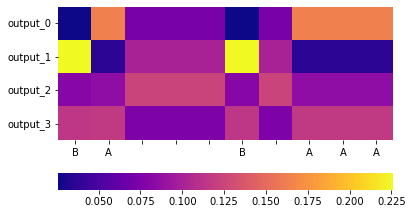

In [11]:
_ = test(self_att=False)

# With Self-Attention

In [12]:
loss_hist = train(print_every=250, self_att=True)

Iteration 250 - Loss 0.8010529279708862
Iteration 500 - Loss 0.2229360044002533
Iteration 750 - Loss 0.1380462497472763
Iteration 1000 - Loss 0.086012102663517
Iteration 1250 - Loss 0.0715286061167717
Iteration 1500 - Loss 0.06371934711933136
Iteration 1750 - Loss 0.040700457990169525
Iteration 2000 - Loss 0.10527150332927704
Iteration 2000 - Loss 0.10527150332927704
Training complete!



Input: 
[[['C']
  ['C']
  [' ']
  [' ']
  ['A']
  ['C']
  ['C']
  ['B']
  ['B']
  [' ']]]

Prediction: 
[[1 2 4 1]]

Encoder-Decoder Attention: 
Output step 0 attended mainly to Input steps: [4]
[0.081, 0.081, 0.109, 0.109, 0.242, 0.081, 0.081, 0.055, 0.055, 0.109]
Output step 1 attended mainly to Input steps: [8]
[0.068, 0.068, 0.087, 0.087, 0.055, 0.068, 0.068, 0.205, 0.205, 0.087]
Output step 2 attended mainly to Input steps: [0 1 5 6]
[0.175, 0.175, 0.061, 0.061, 0.037, 0.175, 0.175, 0.041, 0.041, 0.061]
Output step 3 attended mainly to Input steps: [7 8]
[0.082, 0.082, 0.078, 0.078, 0.141, 0.082, 0.082, 0.149, 0.149, 0.078]


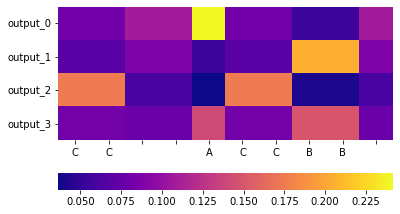


Self-Attention: 
Attention of Output step 0:
[1.0, 0.0, 0.0, 0.0]
Attention of Output step 1:
[0.0, 1.0, 0.0, 0.0]
Attention of Output step 2:
[0.0, 0.0, 1.0, 0.0]
Attention of Output step 3:
[0.021, 0.603, 0.001, 0.375]


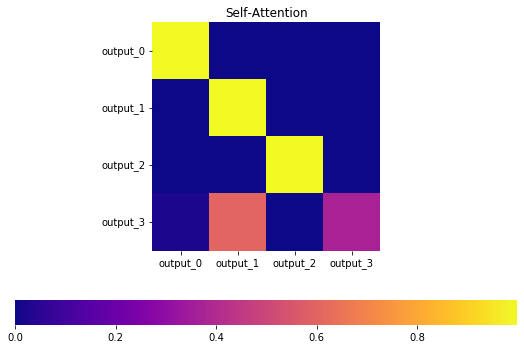

In [13]:
samples, labels, predictions, attention, self_attention = test(self_att=True)